In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sharelib import *
from report import *
import logging
from pathlib import Path
import json
import glob
import sys
import pickle

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

jenkinsURL = getArgs(1,"")
mlflowMinioFolder = getArgs(2,"")
mlflowTrainingFileLimit = int(getArgs(13,100))
jenkinsBuildID = getArgs(14,"1")

In [4]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata6' 
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)
        if (xcount == mlflowTrainingFileLimit):
            break

xcount:  1
xcount:  2
xcount:  3
xcount:  4
xcount:  5
xcount:  6
xcount:  7
xcount:  8
xcount:  9
xcount:  10
xcount:  11
xcount:  12
xcount:  13
xcount:  14
xcount:  15
xcount:  16
xcount:  17
xcount:  18
xcount:  19
xcount:  20
xcount:  21
xcount:  22
xcount:  23
xcount:  24
xcount:  25
xcount:  26
xcount:  27
xcount:  28
xcount:  29
xcount:  30
xcount:  31
xcount:  32
xcount:  33
xcount:  34
xcount:  35
xcount:  36
xcount:  37
xcount:  38
xcount:  39
xcount:  40
xcount:  41
xcount:  42
xcount:  43
xcount:  44
xcount:  45
xcount:  46
xcount:  47
xcount:  48
xcount:  49
xcount:  50
xcount:  51
xcount:  52
xcount:  53
xcount:  54
xcount:  55
xcount:  56
xcount:  57
xcount:  58
xcount:  59
xcount:  60
xcount:  61
xcount:  62
xcount:  63
xcount:  64
xcount:  65
xcount:  66
xcount:  67
xcount:  68
xcount:  69
xcount:  70
xcount:  71
xcount:  72
xcount:  73
xcount:  74
xcount:  75
xcount:  76
xcount:  77
xcount:  78
xcount:  79
xcount:  80
xcount:  81
xcount:  82
xcount:  83
xcount:  84
x

In [5]:
    np.set_printoptions(threshold=sys.maxsize)
    
    df_categories = pd.concat([df["ads_ts_hh"]], axis=1, sort=False,)
    print("-------------- Count Record --------------")
    print(df_categories.shape[0])
    print("-------------- Count Record --------------")
    print("-------------- Count HH --------------")
    print(df_categories.value_counts().to_string())
    print("-------------- Count HH --------------")

    X = df_categories
    print("-------------- X --------------")
    print(X.value_counts().to_string())
    print("-------------- X --------------")

    X_Test = X.mask((X >= 6) & (X <= 18), 99)
    X_Test.mask(X_Test < 99, -1,inplace=True)
    X_Test.mask(X_Test == 99, 1,inplace=True)

    print("-------------- Show X --------------")
    print(X)
    print("-------------- Show X --------------")

    print("-------------- Show X_Test --------------")
    print(X_Test)
    print("-------------- Show X_Test --------------")

-------------- Count Record --------------
15803
-------------- Count Record --------------
-------------- Count HH --------------
ads_ts_hh
8            2942
9            2828
11           1999
13           1470
14           1179
10           1090
15            857
16            664
12            663
6             565
7             284
17            244
21            206
18            169
20            156
5              96
19             87
22             59
2              57
23             54
4              43
3              42
0              26
1              23
-------------- Count HH --------------
-------------- X --------------
ads_ts_hh
8            2942
9            2828
11           1999
13           1470
14           1179
10           1090
15            857
16            664
12            663
6             565
7             284
17            244
21            206
18            169
20            156
5              96
19             87
22             59
2              57
23  

In [9]:
# Call and fit the Local Outlier Factor detector
setNNeighbors = int((df_categories.shape[0]/3)) # /30 This is best scenario but memory 64GB still OMM killed
print("set n_neighbors : " , setNNeighbors)
lof_detector = LocalOutlierFactor(n_neighbors=setNNeighbors, contamination=0.1,novelty=True).fit(X.values)

print("-------------- Model Size (MB) --------------")
print("{:.2f}".format(sys.getsizeof(pickle.dumps(lof_detector))/(1024*1024)))
print("-------------- Model Size (MB) --------------")

lof_detect = lof_detector.predict(X)

recordDetect,countDetect = np.unique(lof_detect, return_counts=True)
print("--------------Count Anomaly VS Normal-------------")
print(recordDetect)
print(countDetect)

if (len(countDetect) == 1):
    row_to_be_added = countDetect
    countDetect = np.append(np.array([0]),row_to_be_added,axis=0)

print("Anomaly = " , countDetect[0] , "record with " , (countDetect[0])*100/(countDetect[0]+countDetect[1]) ," %")
print("Normal  = " , countDetect[1] , "record with " , (countDetect[1])*100/(countDetect[0]+countDetect[1]) ," %")
print("--------------Count Anomaly VS Normal-------------")
htmlAnomalyVSNormally = '''
<table class="table table-striped">
    <th>Type</th><th class=right-aligned>Record</th><th class=right-aligned>%Record</th>
    <tr><td>Anomaly</td><td class=right-aligned>''' + str(countDetect[0]) + '''</td><td class=right-aligned> ''' + str((countDetect[0])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
    <tr><td>Normal</td><td class=right-aligned>''' + str(countDetect[1]) + '''</td><td class=right-aligned> ''' + str((countDetect[1])*100/(countDetect[0]+countDetect[1])) + '''</td></tr>
</table>
'''

print("-------------- List HH with Prediction -------------")
htmlItem = ""
for index, value in df_categories.value_counts().items():
    tempdf = pd.DataFrame([
        [index[0]]
    ], columns=['ads_ts_hh'])
    predictData = lof_detector.predict(tempdf)
    print(index[0]  , " | count ="  , value , " | result =" , dataPredictionToString(predictData[0]))
    
    htmlItem = htmlItem + "<tr><td>" + str(index[0]) + "</td><td class=right-aligned>" + str(value)+ "</td><td>" + dataPredictionToString(predictData[0]) + "</td><tr>"

print("-------------- List HH with Prediction -------------")

htmlCountryPrediction = '''
<table class="table table-striped">
    <th>HH</th><th class=right-aligned>Amount</th><th>Prediction</th>
    ''' + htmlItem + '''
</table>
'''

set n_neighbors :  3000
-------------- Model Size (MB) --------------
362.35
-------------- Model Size (MB) --------------
--------------Count Anomaly VS Normal-------------
[-1  1]
[  510 15293]
Anomaly =  510 record with  3.2272353350629626  %
Normal  =  15293 record with  96.77276466493704  %
--------------Count Anomaly VS Normal-------------
-------------- List HH with Prediction -------------
8  | count = 2942  | result = Normally
9  | count = 2828  | result = Normally
11  | count = 1999  | result = Normally
13  | count = 1470  | result = Normally
14  | count = 1179  | result = Normally
10  | count = 1090  | result = Normally
15  | count = 857  | result = Normally
16  | count = 664  | result = Normally
12  | count = 663  | result = Normally
6  | count = 565  | result = Normally
7  | count = 284  | result = Normally
17  | count = 244  | result = Normally
21  | count = 206  | result = Anomaly
18  | count = 169  | result = Normally
20  | count = 156  | result = Normally
5  | count = 

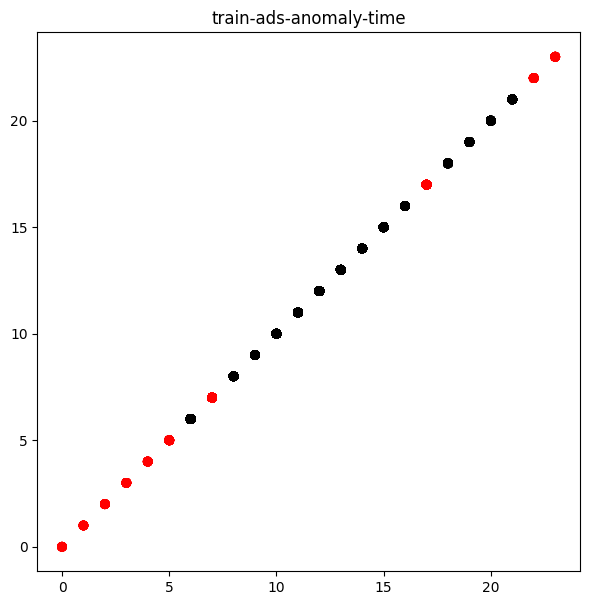

In [43]:
plt.figure(figsize=(7,7))
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 0], c=lof_detect, cmap="flag", alpha=0.5)
plt.title("train-ads-anomaly-time")
plt.savefig('images/train-ads-anomaly-time.png')
plt.show()

In [44]:
print("-------------- Machine Learning - Confusion Matrix -------------")
Accuracy = metrics.accuracy_score(X_Test, lof_detect)
print("Accuracy : " , Accuracy)
Precision = metrics.precision_score(X_Test, lof_detect)
print("Precision : " , Precision)
Sensitivity_recall = metrics.recall_score(X_Test, lof_detect)
print("Sensitivity_recall : " , Sensitivity_recall)
Specificity = metrics.recall_score(X_Test, lof_detect, pos_label=-1)
print("Specificity : " , Specificity)
F1_score = metrics.f1_score(X_Test, lof_detect)
print("F1_score : " , F1_score)
print("-------------- Machine Learning - Confusion Matrix -------------")

htmlMatrix = '''
<table class="table table-striped">
    <th>Type</th><th>Meaning</th><th class=right-aligned>Score</th>
    <tr><td>Accuracy</td><td>The proportion of correctly predicted cases</td><td class=right-aligned>''' + str(Accuracy) + '''</td></tr>
    <tr><td>Precision</td><td>Positive Predictive Value</td><td class=right-aligned>''' + str(Precision) + '''</td></tr>
    <tr><td>Sensitivity_recall</td><td> True Positive Rate</td><td class=right-aligned>''' + str(Sensitivity_recall) + '''</td></tr>
    <tr><td>Specificity</td><td>True Negative Rate</td><td class=right-aligned>''' + str(Specificity) + '''</td></tr>
    <tr><td>F1_score</td><td>Balances precision and recall</td><td class=right-aligned>''' + str(F1_score) + '''</td></tr>    
</table>
'''

-------------- Machine Learning - Confusion Matrix -------------
Accuracy :  0.9251407960513827
Precision :  0.9204705882352942
Sensitivity_recall :  1.0
Specificity :  0.4396020843202274
F1_score :  0.9585885812300907
-------------- Machine Learning - Confusion Matrix -------------


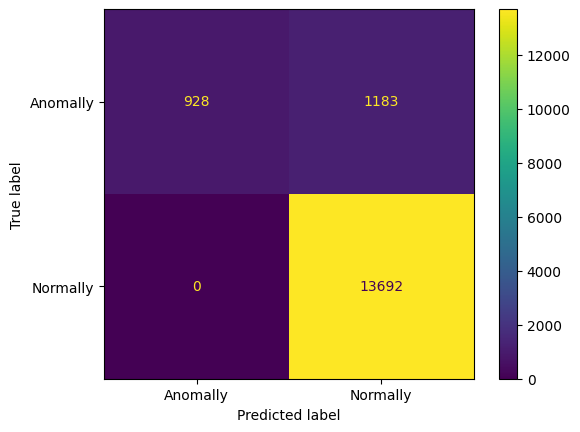

In [45]:
confusion_matrix = metrics.confusion_matrix(X_Test, lof_detect)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Anomally", "Normally"])
cm_display.plot()
plt.savefig('images/train-ads-anomaly-time-confusion-matrix.png')
plt.show()

In [46]:
summary_table = '''
<p>Count Record : ''' + str(df_categories.shape[0]) + '''</p>
<h2>Local Outlier Factor (LOF)</h2>
<p>n_neighbors : ''' + str(setNNeighbors) + '''</p>
''' + htmlAnomalyVSNormally + '''
''' + htmlCountryPrediction + '''
<table class="table table-striped">
<th>Local Outlier Factor (LOF)</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-port.png" alt="train-ads-anomaly-dest-country-port.png"></td>
</tr>
    </table>
<table class="table table-striped">
<th>confusion-matrix</th>
<tr>
    <td><img src="train-ads-anomaly-dest-country-port-confusion-matrix.png" alt="confusion-matrix"></td>
</tr>
</table>
''' + htmlMatrix + '''
'''

In [47]:
html_string = mainReportHTML("train-ads-anomaly-time",summary_table)
f = open('report.html','w')
f.write(html_string)
f.close()

In [36]:
%set_env MLFLOW_TRACKING_URI=http://127.0.0.1:5000
# %set_env MLFLOW_TRACKING_URI=http://mlflow.rtarf-ml.its-software-services.com/
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
# export MLFLOW_TRACKING_USERNAME=user 
# export MLFLOW_TRACKING_PASSWORD=pwd

experiment = mlflow.set_experiment(experiment_name='ads-anomaly-time')
experiment_id = experiment.experiment_id

run_description = f"""
### Note
**All information** * about Training * ~~ML here~~ .
Jenkins URL: [{jenkinsURL}]({jenkinsURL})
Report: [{reportURL}]({reportURL})
"""

with mlflow.start_run(experiment_id=experiment_id,description=run_description):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.doctor()
    mlflow.log_param("MlflowMinioFolder", mlflowMinioFolder)
    mlflow.log_param("SampleFile", xcount)
    mlflow.log_param("SampleRows", X.shape[0])
    # mlflow.set_tag("JenkinsURL",jenkinsURL)

    mlflow.log_metric("Anomaly", str((countDetect[0])*100/(countDetect[0]+countDetect[1])))
    mlflow.log_metric("Normal", str((countDetect[1])*100/(countDetect[0]+countDetect[1])))
    mlflow.sklearn.log_model(lof_detector, "model", registered_model_name="ads-anomaly-by-time")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

env: MLFLOW_TRACKING_URI=http://127.0.0.1:5000
Artifact Location: mlflow-artifacts:/867019726828514942
artifact uri : mlflow-artifacts:/867019726828514942/5754564799bd493fb75a0a37ff51399f/artifacts
System information: Windows 10.0.19045
Python version: 3.9.7
MLflow version: 2.1.1
MLflow module location: C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\mlflow\__init__.py
Tracking URI: http://127.0.0.1:5000
Registry URI: http://127.0.0.1:5000
Active experiment ID: 867019726828514942
Active run ID: 5754564799bd493fb75a0a37ff51399f
Active run artifact URI: mlflow-artifacts:/867019726828514942/5754564799bd493fb75a0a37ff51399f/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_URI: http://127.0.0.1:5000
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  alembic: 1.12.0
  click: 8.1.7
  cloudpickle: 2.2.1
  databricks-cli: 0.17.8
  docker: 6.1.3
  entrypoints: 0.4
  gitpython: 3.1.37
  importlib-metadata: 5.2.0
  markdown: 3.4.4
  matplotlib: 3.8.0
  numpy: 1.25.2
  

Registered model 'ads-anomaly-by-time' already exists. Creating a new version of this model...
2023/11/12 22:46:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ads-anomaly-by-time, version 2
Created version '2' of model 'ads-anomaly-by-time'.


Model saved in run 5754564799bd493fb75a0a37ff51399f


In [37]:
!mlflow models serve -m mlflow-artifacts:/867019726828514942/eb1fbf130cea45bc9ba8beab7f1cdb24/artifacts/model -p 1235 --no-conda

^C


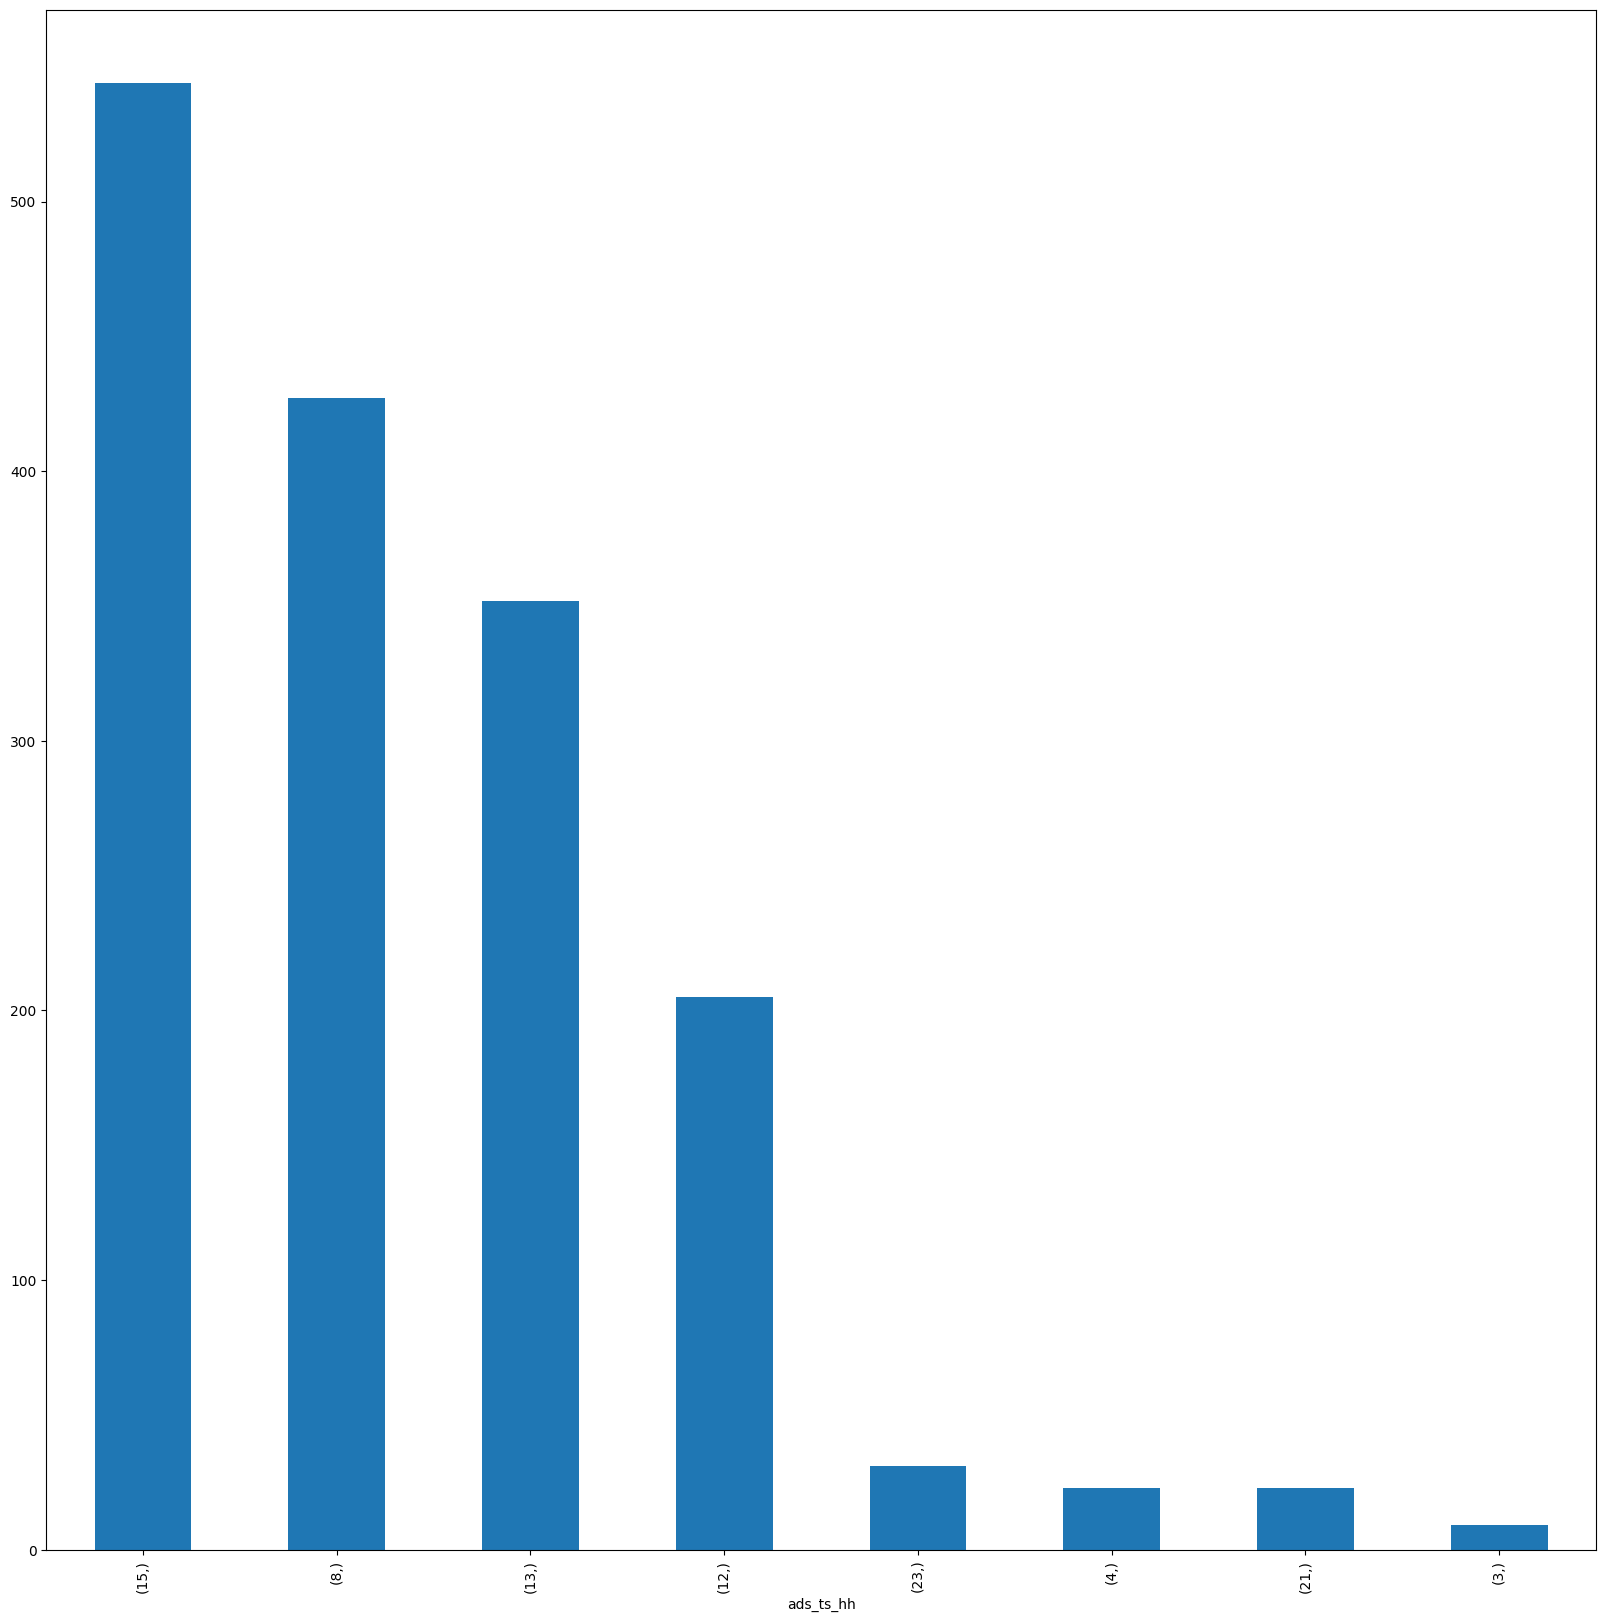

In [ ]:
# Plot the conparison between actual and predicted y
df_categories.value_counts()[: :].plot(kind="bar", figsize=(20,20))
plt.show()